In [1]:
import argparse
import logging
import os
import sys

import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split

sys.path.append("..")
sys.path.append("../scripts/")
import superlayer.utils

from scripts import eval_net, train_net, get_args

from superlayer.models import UNet, TiedUNet
from superlayer.utils import BrainD, dice_coeff, one_hot, plot_img_array, plot_side_by_side

In [2]:
dir_img = '/home/gid-dalcaav/projects/neuron/data/t1_mix/proc/resize256-crop_x32-slice100/train/vols/'
dir_mask = '/home/gid-dalcaav/projects/neuron/data/t1_mix/proc/resize256-crop_x32-slice100/train/asegs/'
dir_checkpoint_1 = 'checkpoints_1/'
dir_checkpoint_2 = 'checkpoints_2/'

np.set_printoptions(threshold=sys.maxsize)
torch.set_printoptions(threshold=10_000)

In [3]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
args = get_args()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

INFO: Using device cuda


In [4]:
target_label_numbers = [0,2,3,4,10,16,17,28,31,41,42,43,49,53,63]
val_percent = 0.1
batch_size = args.batchsize
lr = args.lr
img_scale = args.scale

dataset = BrainD(dir_img, dir_mask, label_numbers=target_label_numbers)
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - 2 * n_val
n_test = n_val
train, val, test = random_split(dataset, [n_train, n_val, n_test])

train_loader = DataLoader(train, batch_size=8, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val, batch_size=8, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

writer = SummaryWriter(comment=f'LR_{lr}_BS_{batch_size}_SCALE_{img_scale}')

INFO: Creating dataset with 7329 examples


In [5]:
one_example = next(iter(train_loader))

image = one_example['image'][0]
mask = one_example['mask'][0]

print(image.shape)
print(mask.shape)

sq_img = image.squeeze(0).squeeze(0)
sq_msk = mask.squeeze(0).squeeze(0)

torch.Size([1, 160, 192])
torch.Size([1, 160, 192])


torch.Size([160, 192])


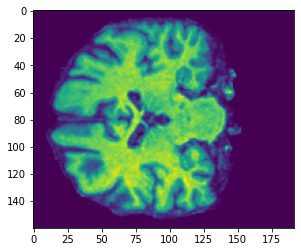

In [6]:
print(sq_img.shape)
plt.imshow(sq_img)

torch.Size([160, 192])


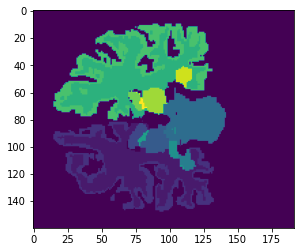

In [7]:
print(sq_msk.shape)
plt.imshow(sq_msk)

In [8]:
net1 = UNet(n_channels=1, n_classes=15, bilinear=True)

logging.info(f'Network:\n'
             f'\t{net1.n_channels} input channels\n'
             f'\t{net1.n_classes} output channels (classes)\n'
             f'\t{"Bilinear" if net1.bilinear else "Transposed conv"} upscaling')

net1.to(device=device)
train_scores1, val_scores1, train_var_1, val_var_1 = train_net(net=net1,
                                                                epochs=args.epochs,
                                                                batch_size=args.batchsize,
                                                                lr=args.lr,
                                                                device=device,
                                                                img_scale=args.scale,
                                                                val_percent=args.val / 100,
                                                                checkpoint=1,
                                                                target_label_numbers=target_label_numbers,
                                                                dataset=dataset,
                                                                train_loader=train_loader,
                                                                val_loader=val_loader,
                                                                writer=writer)

INFO: Network:
	1 input channels
	15 output channels (classes)
	Bilinear upscaling
INFO: Starting training:
        Epochs:          3
        Batch size:      8
        Learning rate:   0.001
        Training size:   6597
        Validation size: 732
        Checkpoints:     True
        Device:          cuda
        Images scaling:  1
    
Validation round:  99%|█████████▉| 90/91 [00:11<00:00, 10.80batch/s]
                                                                    INFO: Validation Dice Loss: 0.06502492095415409
Validation round:  74%|███████▎  | 67/91 [00:09<00:03,  7.85batch/s]


Validation round:  99%|█████████▉| 90/91 [00:11<00:00, 10.61batch/s]
                                                                    INFO: Validation Dice Loss: 0.06868570461705491
Epoch 1/3:  33%|███▎      | 2184/6597 [01:30<01:53, 38.75img/s, loss (batch)=0.114]
                                                                    INFO: Validation Dice Loss: 0.06059608673983878
Validation round:  77%|███████▋  | 70/91 [00:08<00:02,  9.73batch/s]


Validation round: 100%|██████████| 91/91 [00:10<00:00, 10.29batch/s]
                                                                    INFO: Validation Dice Loss: 0.06673043941730981
Validation round: 100%|██████████| 91/91 [00:11<00:00, 10.26batch/s]
                                                                    INFO: Validation Dice Loss: 0.056130003880013477
Validation round:  68%|██████▊   | 62/91 [00:07<00:03,  8.86batch/s]


Validation round: 100%|██████████| 91/91 [00:11<00:00,  8.62batch/s]
                                                                    INFO: Validation Dice Loss: 0.05186655126757674
Validation round: 100%|██████████| 91/91 [00:11<00:00,  9.17batch/s]
                                                                    INFO: Validation Dice Loss: 0.04789474934012025
Validation round:  48%|████▊     | 44/91 [00:06<00:06,  7.29batch/s]


Validation round: 100%|██████████| 91/91 [00:10<00:00, 10.00batch/s]
                                                                    INFO: Validation Dice Loss: 0.047533721632354864
Epoch 1/3:  89%|████████▉ | 5865/6597 [03:57<00:29, 24.66img/s, loss (batch)=0.0852]
INFO: Checkpoint 1 saved !
Validation round: 100%|██████████| 91/91 [00:10<00:00,  9.67batch/s]
                                                                    INFO: Validation Dice Loss: 0.04593543945760517
Validation round:  38%|███▊      | 35/91 [00:05<00:06,  9.10batch/s]


Validation round: 100%|██████████| 91/91 [00:11<00:00,  8.22batch/s]
                                                                    INFO: Validation Dice Loss: 0.04906701018194576
Validation round: 100%|██████████| 91/91 [00:10<00:00,  9.85batch/s]
                                                                    INFO: Validation Dice Loss: 0.04658385317076694
Validation round:  33%|███▎      | 30/91 [00:04<00:06,  9.15batch/s]


Validation round: 100%|██████████| 91/91 [00:10<00:00,  8.98batch/s]
                                                                    INFO: Validation Dice Loss: 0.0489919595010988
Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  9.66batch/s]
                                                                    INFO: Validation Dice Loss: 0.04108118781676659
Validation round:  27%|██▋       | 25/91 [00:04<00:07,  9.13batch/s]


Validation round:  99%|█████████▉| 90/91 [00:11<00:00, 10.28batch/s]
                                                                    INFO: Validation Dice Loss: 0.04066491429949855
Validation round: 100%|██████████| 91/91 [00:10<00:00, 11.94batch/s]
                                                                    INFO: Validation Dice Loss: 0.04118394155751218
Validation round:  33%|███▎      | 30/91 [00:04<00:06,  9.33batch/s]


Validation round: 100%|██████████| 91/91 [00:11<00:00,  9.88batch/s]
                                                                    INFO: Validation Dice Loss: 0.04068218695593404
Epoch 2/3:  89%|████████▉ | 5865/6597 [03:57<00:29, 24.74img/s, loss (batch)=0.079] 
INFO: Checkpoint 2 saved !
Validation round: 100%|██████████| 91/91 [00:11<00:00, 10.21batch/s]
                                                                    INFO: Validation Dice Loss: 0.04009611396999149
Validation round:   7%|▋         | 6/91 [00:02<00:56,  1.50batch/s]


Validation round: 100%|██████████| 91/91 [00:10<00:00, 10.63batch/s]
                                                                    INFO: Validation Dice Loss: 0.040021641486948666
Validation round: 100%|██████████| 91/91 [00:10<00:00, 10.15batch/s]
                                                                    INFO: Validation Dice Loss: 0.039831334336118386
Validation round:   9%|▉         | 8/91 [00:02<00:24,  3.36batch/s]


Validation round: 100%|██████████| 91/91 [00:10<00:00, 10.74batch/s]
                                                                    INFO: Validation Dice Loss: 0.039938601081842905
Validation round: 100%|██████████| 91/91 [00:10<00:00,  8.53batch/s]
                                                                    INFO: Validation Dice Loss: 0.0397051378757089


Validation round: 100%|██████████| 91/91 [00:10<00:00,  9.17batch/s]
                                                                    INFO: Validation Dice Loss: 0.03960495671400657
Validation round:  99%|█████████▉| 90/91 [00:10<00:00, 10.91batch/s]
                                                                    INFO: Validation Dice Loss: 0.03931085896361005


Validation round:  99%|█████████▉| 90/91 [00:10<00:00, 10.29batch/s]
                                                                    INFO: Validation Dice Loss: 0.03899035733807218
Epoch 3/3:  89%|████████▉ | 5865/6597 [03:56<00:29, 24.82img/s, loss (batch)=0.179] 
INFO: Checkpoint 3 saved !


In [9]:
net2 = TiedUNet(in_channels=1, nshared=64, n_classes=15, enc_depth=4, bilinear=True)

logging.info(f'Network:\n'
             f'\t{net2.in_channels} input channels\n'
             f'\t{net2.n_classes} output channels (classes)\n'
             f'\t{"Bilinear" if net2.bilinear else "Transposed conv"} upscaling')

net2.to(device=device)
train_scores2, val_scores2, train_var_2, val_var_2 = train_net(net=net2,
                                                                epochs=args.epochs,
                                                                batch_size=args.batchsize,
                                                                lr=args.lr,
                                                                device=device,
                                                                img_scale=args.scale,
                                                                val_percent=args.val / 100,
                                                                checkpoint=2,
                                                                target_label_numbers=target_label_numbers,
                                                                dataset=dataset,
                                                                train_loader=train_loader,
                                                                val_loader=val_loader,
                                                                writer=writer)

INFO: Network:
	1 input channels
	15 output channels (classes)
	Bilinear upscaling
INFO: Starting training:
        Epochs:          3
        Batch size:      8
        Learning rate:   0.001
        Training size:   6597
        Validation size: 732
        Checkpoints:     True
        Device:          cuda
        Images scaling:  1
    
Validation round:  99%|█████████▉| 90/91 [00:10<00:00, 11.14batch/s]
                                                                    INFO: Validation Dice Loss: 0.7780821323394775
Validation round: 100%|██████████| 91/91 [00:11<00:00, 11.08batch/s]
                                                                    INFO: Validation Dice Loss: 0.7790938373450395
Validation round:  12%|█▏        | 11/91 [00:02<00:30,  2.62batch/s]


Validation round: 100%|██████████| 91/91 [00:10<00:00, 10.46batch/s]
                                                                    INFO: Validation Dice Loss: 0.7701765357793032
Validation round: 100%|██████████| 91/91 [00:10<00:00,  8.59batch/s]
                                                                    INFO: Validation Dice Loss: 0.7734864792980991
Validation round:  44%|████▍     | 40/91 [00:05<00:04, 10.77batch/s]


Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  9.12batch/s]
                                                                    INFO: Validation Dice Loss: 0.7642856679119907
Validation round:  99%|█████████▉| 90/91 [00:11<00:00,  8.26batch/s]
                                                                    INFO: Validation Dice Loss: 0.7713009610280885
Validation round:  79%|███████▉  | 72/91 [00:08<00:01, 12.66batch/s]


Validation round: 100%|██████████| 91/91 [00:10<00:00,  8.91batch/s]
                                                                    INFO: Validation Dice Loss: 0.7587264330832513
Validation round: 100%|██████████| 91/91 [00:11<00:00,  9.43batch/s]
                                                                    INFO: Validation Dice Loss: 0.7596941963656918
Epoch 1/3:  89%|████████▉ | 5865/6597 [02:58<00:22, 32.94img/s, loss (batch)=0.1]   
INFO: Checkpoint 1 saved !
Validation round:  99%|█████████▉| 90/91 [00:10<00:00, 10.16batch/s]
                                                                    INFO: Validation Dice Loss: 0.7724498340061733
Epoch 2/3:  21%|██▏       | 1408/6597 [00:33<01:18, 65.98img/s, loss (batch)=0.125] 


Validation round: 100%|██████████| 91/91 [00:10<00:00, 10.90batch/s]
                                                                    INFO: Validation Dice Loss: 0.757487722150572
Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  9.99batch/s]
                                                                    INFO: Validation Dice Loss: 0.7658965548316201
Validation round:  27%|██▋       | 25/91 [00:03<00:08,  7.46batch/s]


Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  9.05batch/s]
                                                                    INFO: Validation Dice Loss: 0.7726645960912599
Validation round:  99%|█████████▉| 90/91 [00:10<00:00, 11.06batch/s]
                                                                    INFO: Validation Dice Loss: 0.8022488735534332
Validation round:  60%|██████    | 55/91 [00:07<00:03, 11.15batch/s]


Validation round: 100%|██████████| 91/91 [00:10<00:00, 10.49batch/s]
                                                                    INFO: Validation Dice Loss: 0.7747435491163652
Validation round: 100%|██████████| 91/91 [00:10<00:00,  7.17batch/s]
                                                                    INFO: Validation Dice Loss: 0.7758678184760796
Validation round:  91%|█████████ | 83/91 [00:10<00:00,  8.88batch/s]


Validation round: 100%|██████████| 91/91 [00:10<00:00, 11.12batch/s]
                                                                    INFO: Validation Dice Loss: 0.7725054457947448
Epoch 2/3:  89%|████████▉ | 5865/6597 [02:55<00:21, 33.35img/s, loss (batch)=0.0807]
INFO: Checkpoint 2 saved !
Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  9.28batch/s]
                                                                    INFO: Validation Dice Loss: 0.7741298197389959
Validation round:  99%|█████████▉| 90/91 [00:10<00:00, 10.83batch/s]
                                                                    INFO: Validation Dice Loss: 0.77587079674333
Validation round:   9%|▉         | 8/91 [00:02<00:36,  2.25batch/s]


Validation round: 100%|██████████| 91/91 [00:11<00:00,  8.40batch/s]
                                                                    INFO: Validation Dice Loss: 0.7741911987681965
Validation round: 100%|██████████| 91/91 [00:10<00:00, 11.37batch/s]
                                                                    INFO: Validation Dice Loss: 0.7733806993935134
Validation round:  38%|███▊      | 35/91 [00:04<00:05,  9.89batch/s]


Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  9.90batch/s]
                                                                    INFO: Validation Dice Loss: 0.7748198843264318
Validation round:  99%|█████████▉| 90/91 [00:11<00:00, 11.70batch/s]
                                                                    INFO: Validation Dice Loss: 0.7734596126682156
Validation round:  74%|███████▎  | 67/91 [00:08<00:02,  8.27batch/s]


Validation round: 100%|██████████| 91/91 [00:11<00:00,  8.99batch/s]
                                                                    INFO: Validation Dice Loss: 0.7727477570156475
Validation round:  99%|█████████▉| 90/91 [00:10<00:00,  8.95batch/s]
                                                                    INFO: Validation Dice Loss: 0.7747438772694095
Epoch 3/3:  89%|████████▉ | 5865/6597 [02:57<00:22, 33.04img/s, loss (batch)=0.0944]
INFO: Checkpoint 3 saved !


configuring plot one


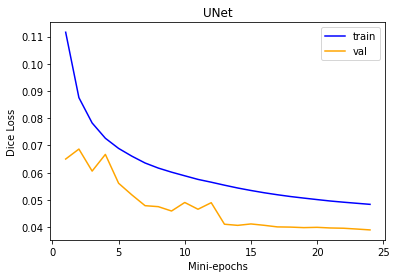

In [10]:
print("configuring plot one")
domain = len(train_scores1)
x_values = [i+1 for i in range(domain)]
plt.title("UNet")
plt.xlabel("Mini-epochs")
plt.ylabel("Dice Loss")
plt.plot(x_values, train_scores1, color="blue", label="train")
plt.plot(x_values, val_scores1, color="orange", label="val")
plt.legend()
plt.show()
plt.close()

configuring plot two


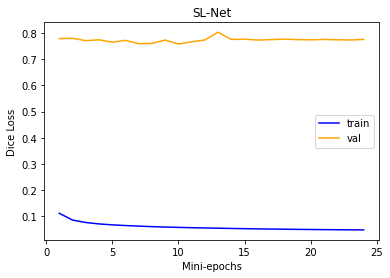

In [11]:
print("configuring plot two")
domain = len(train_scores2)
x_values = [i+1 for i in range(domain)]
plt.title("SL-Net")
plt.xlabel("Mini-epochs")
plt.ylabel("Dice Loss")
plt.plot(x_values, train_scores2, color="blue", label="train")
plt.plot(x_values, val_scores2, color="orange", label="val")
plt.legend()
plt.show()
plt.close()

In [12]:
import math

# Create another simulation dataset for test
train_loader = DataLoader(train, batch_size=2, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)
val_loader = DataLoader(val, batch_size=2, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)
test_loader = DataLoader(test, batch_size=2, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

# Get the first batch
train_batch = next(iter(train_loader))
val_batch = next(iter(val_loader))
test_batch = next(iter(test_loader))

inputs_train = train_batch['image']
labels_train = train_batch['mask']

inputs_val = val_batch['image']
labels_val = val_batch['mask']

inputs_test = test_batch['image']
labels_test = test_batch['mask']

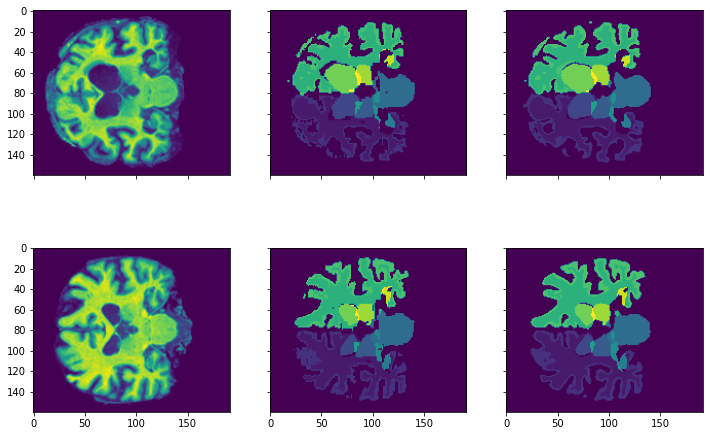

In [13]:
net1.eval() 
inputs = inputs_train.to(device=device, dtype=torch.float32)
labels = labels_train.to(device=device, dtype=torch.float32)
        

# Predict
pred = net1(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

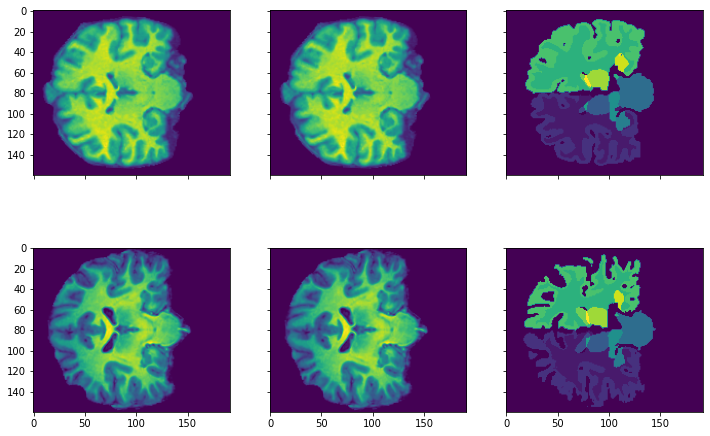

In [14]:
net1.eval() 
inputs = inputs_val.to(device=device, dtype=torch.float32)
labels = inputs_val.to(device=device, dtype=torch.float32)
        

# Predict
pred = net1(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

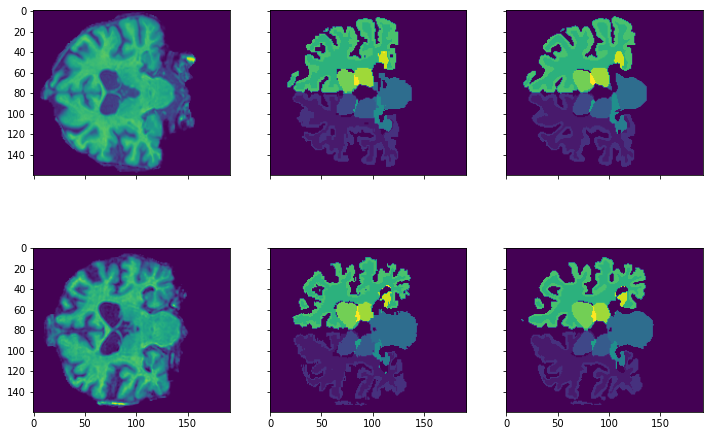

In [15]:
net1.eval() 
inputs = inputs_test.to(device=device, dtype=torch.float32)
labels = labels_test.to(device=device, dtype=torch.float32)
        

# Predict
pred = net1(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

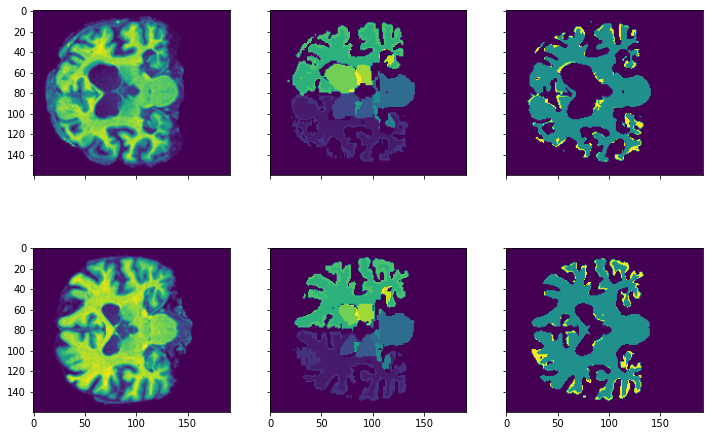

In [16]:
net2.eval()
inputs = inputs_train.to(device=device, dtype=torch.float32)
labels = labels_train.to(device=device, dtype=torch.float32)
        

# Predict
pred = net2(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

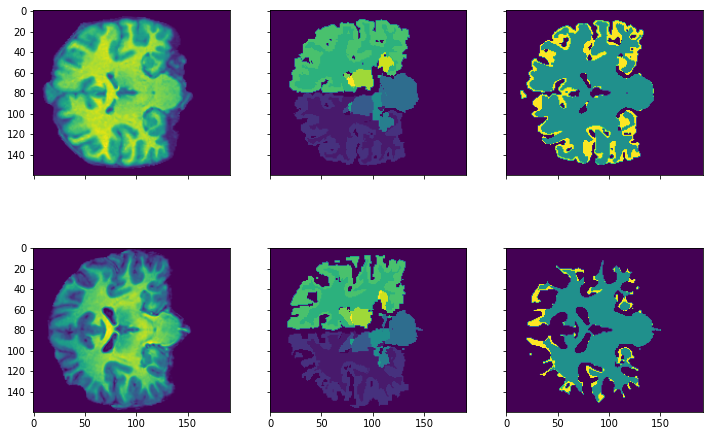

In [17]:
net2.eval()
inputs = inputs_val.to(device=device, dtype=torch.float32)
labels = labels_val.to(device=device, dtype=torch.float32)
        

# Predict
pred = net2(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

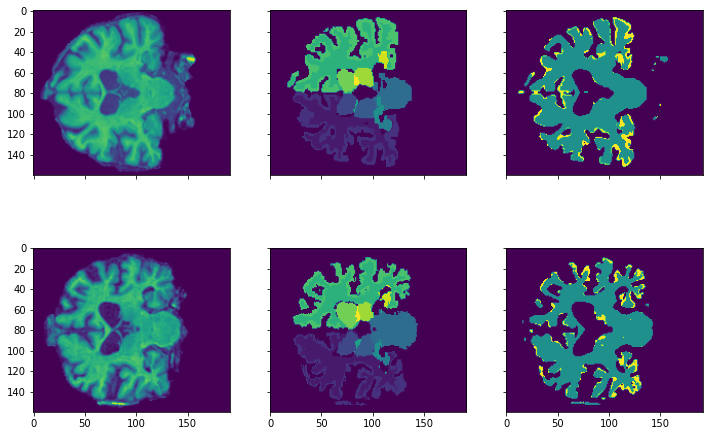

In [18]:
net2.eval()
inputs = inputs_test.to(device=device, dtype=torch.float32)
labels = labels_test.to(device=device, dtype=torch.float32)
        

# Predict
pred = net2(inputs)
# The loss functions include the sigmoid function.
pred = torch.argmax(pred, axis=1).unsqueeze(1)
pred = pred.data.cpu().numpy()

input_images_rgb = [x.squeeze(0) for x in inputs.cpu().numpy()]
target_masks_rgb = [x.squeeze(0) for x in labels.cpu().numpy()]
pred_rgb = [x.squeeze(0) for x in pred]

plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])